In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\Youssef\Desktop\jyptar1\Financial-Fraud-Detection\PS_20174392719_1491204439457_log.csv")
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Column Desciptions:
- step: Represents the time step of the transaction (e.g., hours).
- type: The type of transaction (e.g., PAYMENT, TRANSFER, CASH_OUT).
- amount: The transaction amount.
- nameOrig: Unique identifier of the originating account.
- oldbalanceOrg: Balance of the originating account before the transaction.
- newbalanceOrig: Balance of the originating account after the transaction.
- nameDest: Unique identifier of the destination account.
- oldbalanceDest: Balance of the destination account before the transaction.
- newbalanceDest: Balance of the destination account after the transaction.
- isFraud: Indicates whether the transaction is fraud (1) or not (0).
- isFlaggedFraud: Indicates if the transaction was flagged as suspicious (1) by the system.
- Note: We will remove last two columns for detecting anomalies. However we will use them for evaluating model accuracy after anomaly detection. (unsupervised learning).

In [5]:
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
X.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


## EDA

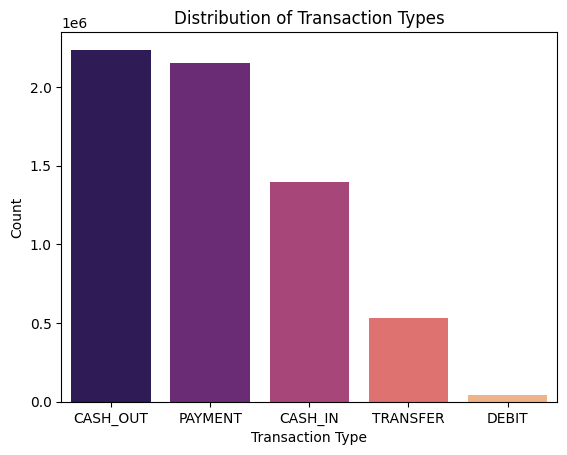

In [6]:
sns.countplot(x='type', data=df, order=df['type'].value_counts().index, palette='magma')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

The chart shows **CASH_OUT** and **PAYMENT** are the most common transaction types, while **DEBIT** is the least frequent.\
Dominant types may influence anomaly detection.

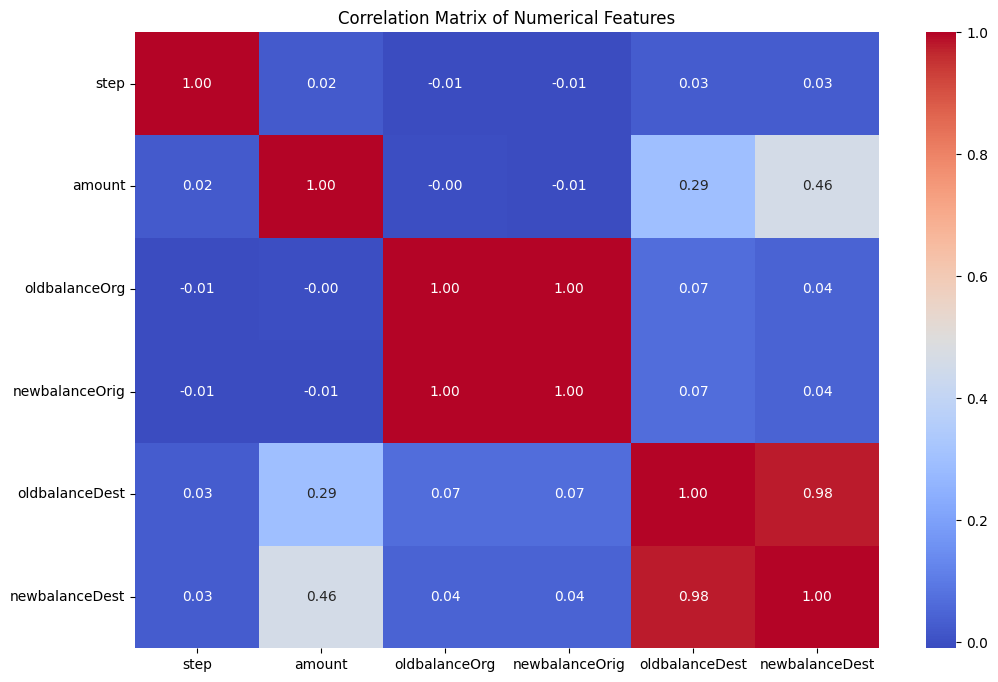

In [7]:
numerical_data = X.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Build and Train the Isolation Forest Model for anomaly detection

In [8]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(n_estimators=100, contamination=0.0001, random_state=42)

# Ensure consistent feature set for training
features = X.select_dtypes(include=['float64', 'int64']).drop(['anomaly_score', 'anomaly'], axis=1, errors='ignore')

# Train the model
iso_forest.fit(features)

# Predict anomalies with the same features
X['anomaly'] = iso_forest.predict(features)
X['anomaly'] = X['anomaly'].map({1: 0, -1: 1})

print(f"Number of anomalies detected: {X['anomaly'].sum()} out of {len(X)} total transactions")

Number of anomalies detected: 634 out of 6362620 total transactions


## Evaluate the Model Using 'isFraud' column

In [9]:
from sklearn.metrics import classification_report, roc_auc_score

X['anomaly_score'] = iso_forest.decision_function(features)

# Compare model predictions to actual fraud labels
y_true = df['isFraud']
y_pred = X['anomaly']

print("Classification Report:")
print(classification_report(y_true, y_pred))

auc_roc = roc_auc_score(y_true, X['anomaly_score'])
print(f"AUC-ROC Score: {auc_roc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.02      0.00      0.00      8213

    accuracy                           1.00   6362620
   macro avg       0.51      0.50      0.50   6362620
weighted avg       1.00      1.00      1.00   6362620

AUC-ROC Score: 0.2432


## Analyze Detected Anomalies

In [10]:
anomalies = X[X['anomaly'] == 1]

print("Summary Statistics of Anomalies:")
print(anomalies.describe())

# Check the distribution of transaction types (if available)
if 'type' in df.columns:
    print("Transaction Types in Anomalies:")
    print(anomalies['type'].value_counts())

Summary Statistics of Anomalies:
             step        amount  oldbalanceOrg  newbalanceOrig  \
count  634.000000  6.340000e+02   6.340000e+02    6.340000e+02   
mean   301.228707  3.712162e+06   1.771210e+07    1.767594e+07   
std    183.290323  8.799434e+06   1.017022e+07    1.000128e+07   
min      8.000000  3.186100e+02   0.000000e+00    0.000000e+00   
25%    181.000000  9.364033e+04   1.255230e+07    1.296250e+07   
50%    324.000000  2.250644e+05   1.995142e+07    2.023221e+07   
75%    382.000000  5.165843e+05   2.505394e+07    2.518817e+07   
max    741.000000  6.015446e+07   5.731626e+07    4.731626e+07   

       oldbalanceDest  newbalanceDest  anomaly  anomaly_score  
count    6.340000e+02    6.340000e+02    634.0     634.000000  
mean     4.017792e+07    4.367833e+07      1.0      -0.009503  
std      3.539458e+07    3.942857e+07      0.0       0.007897  
min      0.000000e+00    0.000000e+00      1.0      -0.035701  
25%      2.193755e+07    2.205390e+07      1.0      

## Visualize Anomalies by Transaction Type

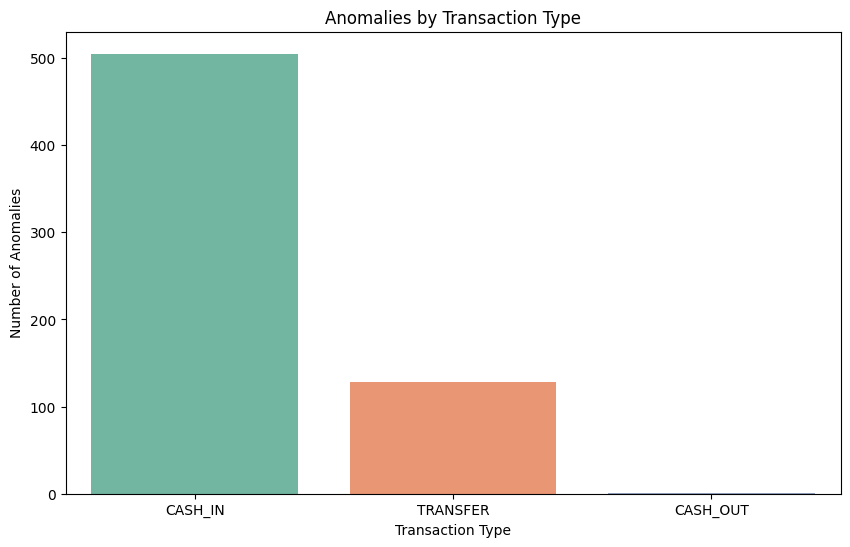

In [11]:
# Count anomalies for each transaction type
if 'type' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=anomalies['type'], order=anomalies['type'].value_counts().index, palette='Set2')
    plt.title('Anomalies by Transaction Type')
    plt.xlabel('Transaction Type')
    plt.ylabel('Number of Anomalies')
    plt.show()